<a href="https://colab.research.google.com/github/elekdra01/Data-Visualization/blob/master/SVM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving tweet.csv to tweet.csv


In [ ]:

df=pd.read_csv('tweet.csv',engine='python',encoding='ISO-8859-1',error_bad_lines=False)


In [ ]:
df.head(2).T 

,0,1
Unnamed: 0,0,1
ID,3.194e+17,3.20818e+17
Authors,CreatrixKali,quincepoacher
clean_tweet,oh yeah colin smash those girls mega kack reiz,it is insane they keep bringing people back wh...
Class,sexism,none
class_num,1,0
Tna,0.5,1
Tsa,0.5,0
Tra,0,0
word_frequency_vector,"[84, 178, 164, 3018, 123, 71, 8, 7, 9]","[15, 3, 1301, 20, 241, 1452, 52, 126, 65, 44, ..."


In [ ]:

# Create a new dataframe with two columns
df1 = df[['Class', 'clean_tweet','class_num','Tna','Tsa','Tra','word_frequency_vector']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['clean_tweet'])]

# Renaming second column for a simpler name
#df1.columns = ['Class', 'Tweets'] 

df1.shape

(9492, 7)

In [ ]:
total = df1['word_frequency_vector'].notnull().sum()
round((total/len(df)*100),1)

98.1

In [ ]:
pd.DataFrame(df.Class.unique()).values

array([['sexism'],
       ['none'],
       ['racism']], dtype=object)

In [ ]:
##df2 = df1.sample(10000, random_state=1).copy()
pd.DataFrame(df1.Class.unique())

,0
0,sexism
1,none
2,racism


In [ ]:
# Create a new column 'category_id' with encoded categories 
df1['class_id'] = df1['Class'].factorize()[0]
category_id_df = df1[['Class', 'class_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['class_id', 'Class']].values)

# New dataframe
df1.head()

,Class,clean_tweet,class_num,Tna,Tsa,Tra,word_frequency_vector,class_id
0,sexism,oh yeah colin smash those girls mega kack reiz,1,0.500000,0.500000,0.000000,"[84, 178, 164, 3018, 123, 71, 8, 7, 9]",0
1,none,it is insane they keep bringing people back wh...,0,1.000000,0.000000,0.000000,"[15, 3, 1301, 20, 241, 1452, 52, 126, 65, 44, ...",1
2,none,mega kack reiz this shit show has more comebac...,0,1.000000,0.000000,0.000000,"[8, 7, 9, 24, 132, 153, 70, 63, 3981, 90, 4670...",1
3,none,sigh oh colin mega kack reiz,0,1.000000,0.000000,0.000000,"[1139, 84, 164, 8, 7, 9]",1
4,sexism,i swear i am not sexist but i honestly just ca...,1,0.414173,0.582306,0.003521,"[2, 844, 2, 22, 5, 26, 18, 2, 589, 28, 286, 33...",0


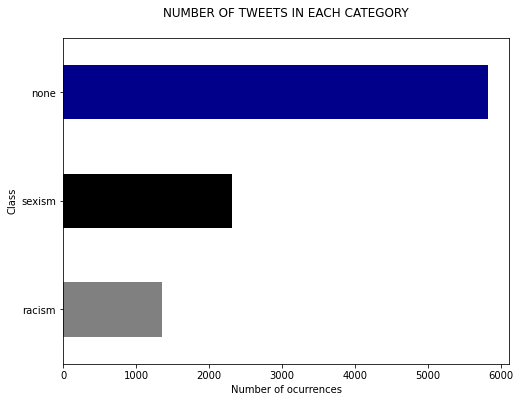

In [ ]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','black','darkblue']
df1.groupby('Class').word_frequency_vector.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF TWEETS IN EACH CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df1.word_frequency_vector).toarray()

labels = df1.class_id

print("Each of the %d tweet is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 9492 tweet is represented by 5297 features (TF-IDF score of unigrams and bigrams)


In [ ]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Class, class_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == class_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Class))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> none:
  * Most Correlated Unigrams are: 76, 18, 26
  * Most Correlated Bigrams are: 36 26, 22 26, 26 18

==> racism:
  * Most Correlated Unigrams are: 124, 76, 41
  * Most Correlated Bigrams are: 215 23, 76 14, 413 173

==> sexism:
  * Most Correlated Unigrams are: 22, 18, 26
  * Most Correlated Bigrams are: 36 26, 22 26, 26 18


In [ ]:
X = df1['word_frequency_vector'] # Collection of documents
y = df1['Class'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.775599,0.045669
LogisticRegression,0.780861,0.062337
MultinomialNB,0.758103,0.065839
RandomForestClassifier,0.626315,0.010569


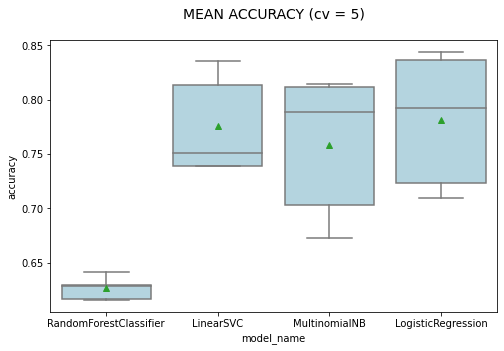

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [ ]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df1.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df1['Class'].unique()))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

      sexism       0.80      0.68      0.74       577
        none       0.81      0.90      0.85      1449
      racism       0.79      0.61      0.69       347

    accuracy                           0.80      2373
   macro avg       0.80      0.73      0.76      2373
weighted avg       0.80      0.80      0.80      2373



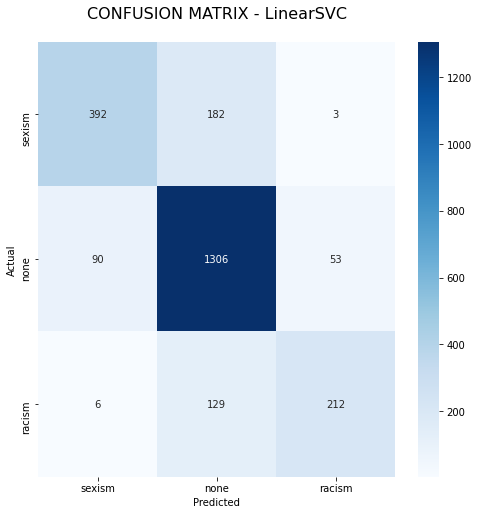

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Class.values, 
            yticklabels=category_id_df.Class.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);